# ISBI 2023: Tutorial on Topological Data Analysis
# [Soheil Kolouri](https://skolouri.github.io/), Department of Computer Science, Vanderbilt University

In this tutorial, we will explore how optimal transport and its sliced variations can be applied to compare persistence diagrams. The accompanying slides for this tutorial can be downloaded from [here](https://drive.google.com/file/d/10brPPjqXYgfoytMfQ3PBLKRXF01cemGp/view?usp=share_link). I would like to acknowledge the invaluable contributions of the members of Vanderbilt's Machine Intelligence and Neural Technologies (MINT) Lab, who made this material possible.

![](./src/mint.png)


## Part 0 - A 30,000 Feet View of Persistent Homology and Persistence Diagrams

Persistent homology is a beautiful mathematical framework used in the field of algebraic topology to study and quantify the topological features of a point set living in a metric space. It aims to capture the multiscale topological information of the point set by analyzing the evolution of its homology groups (i.e., the number and arrangement of holes) as a function of a parameter, such as a distance or a scale parameter. This allows persistent homology to extract robust topological signatures that persist over different scales and provide a comprehensive description of the underlying topological structure of the point set. Persistent homology has applications in various fields, including image processing, machine learning, network analysis, and materials science.

Here we use the phenomenal visualization provided by [Gary Koplik](https://github.com/gjkoplik/pers-hom-examples) to review the high-level ideas behind 0d and 1d persistence diagrams. 

### 0d Persistence Diagrams

A 0d persistence diagram is a visual representation of the evolution of connected components in a dataset as a function of a scale parameter. Consider a set of points in a Euclidean space, and assume that we blow up a ball around each point with an increasing radius. At radius $0$, a connected component for each point is "born." As we increase the radius of these balls, some will intersect. When the first set of two balls intersect, say for points A and B, they form a pair, which will be considered part of a single connected component. This marks the first instance of a connected component's death and leads to the first point on our 0d persistence diagram. Typically, in persistent homology, the earlier-born ball outlives its counterpart in a pair, but since all points are born simultaneously here, we will select the point to die based on its index value. As we blow up the balls further, more and more connected components die until all points are covered. This process is depicted in the following animation, and an interactive version of it is provided by Gary Koplik [here](https://gjkoplik.github.io/pers-hom-examples/0d_pers_2d_data_widget.html). 

![](./src/persistent_homology_0d.gif) 

### 1d Persistence Diagrams

In 1d persistence diagrams, the process of expanding balls around the points in our set remains similar to that of 0d diagrams. However, in contrast to 0d, we now monitor the creation and extinction of loops. A more rigorous definition of "loops" was provided in the previous parts of this tutorial. 

This process is depicted in the following animation, and an interactive version of it is provided by Gary Koplik [here](https://gjkoplik.github.io/pers-hom-examples/1d_pers_2d_data_widget.html). 

![](./src/persistent_homology_1d.gif) 


## Part 1 - Optimal Transport for Comparing Persistence Diagrams

We will begin by examining the standard structure of distances between persistence diagrams and their relationship to the optimal partial transport problem. Next, we will present a straightforward approach to implementing optimal transport for determining distances between persistence diagrams. Finally, we will showcase the application of this method in data analysis, specifically on a subset of permuted MNIST dataset.

## Part 1.1 - Distance between Persistence Diagrams

Let $D_1$ and $D_2$ denote two Persistence Diagrams (PDs), and let $T: D_1\supseteq A \to B \subseteq D_2$ denote a *partial bijection* between $D_1$ and $D_2$. Moreover, let $\Gamma(D_1,D_2)$ denotes the set of all partial matchings between points in $D_1$ and $D_2$ induced by such *partial bijections*.  More precisely, $\Gamma(D_1,D_2):=\big\{ \{(x,T(x))\}_{x\in A} \subseteq D_1\times D_2 ~|~T:D_1\supseteq A \to B \subseteq D_2,~T \text{is a partial matching}\big\}$. The space of PDs is endowed with a partial matching metric defined as ($p\geq 1$) [[1]](#references):

$$d_p(D_1,D_2)=\big(\min_{\gamma\in\Gamma(D_1,D_2)} \sum_{(x,y)\in \gamma} \|x-y\|_p^p+\sum_{z\in (D_1\bigsqcup D_2)\backslash \gamma} \|z-\pi_\Delta(z)\|_p^p\big)^{\frac{1}{p}}$$

where $\pi_\Delta$ is the projection onto the diagonal $\Delta=\{(x,x):x\in \mathbb{R}\}$, and by abuse of notation $(D_1\bigsqcup D_2)\backslash \gamma$ is the set of unmatched points. The figure below demonstrates such partial matching, note that the cost associated with unmatched points is proportional to how far the points are from the diagonal line. 

![](./src/pd_intro.png)


This problem is in essense similar to an optimal partial transportation problem, where $\|x-y\|_p^p$ is the transportation cost, and $\|z-\pi_\Delta(z)\|_p^p$ is the destruction/creation cost. Next, we will discuss these connections. 

## Part 1.2 - Optimal Transport (OT)

In this section, we will provide a brief overview of the optimal transport problem concerning two discrete probability measures. For a more comprehensive introduction to this topic and related problems, we recommend that interested readers refer to [[2]](#references). Let $\mu(x)=\sum_{i=1}^M a_i\delta(x-x_i)$ and $\nu(y)=\sum_{j=1}^N b_j\delta(y-y_j)$ denote two discrete probability measures with $M$ and $N$ particles, respectively, where $\sum_{i=1}^M a_i =\sum_{j=1}^N b_j=1$. Let $\Pi(\mu,\nu)=\{P\in\mathbb{R}_+^{M\times N} | P \mathbf{1}_N=a, P^T \mathbf{1}_M=b\}$ denote the set of transportation plans between the discrete measures $\mu$ and $\nu$, and let $c(x,y)\in\mathbb{R}_+$ denote the transportation cost from $x$ to $y$. Then the optimal transportation problem can be written as the following linear programming problem: 
$$OT(\mu,\nu)= min_{P\in\Pi(\mu,\nu)} \sum_{i=1}^M\sum_{j=1}^N P_{ij}C_{ij}$$
where $C_{ij}=c(x_i,y_j)$. In this tutorial, we use $c(x_i,y_j)=\|x_i-y_j\|_p^p$. The following figure depicts the concept of the transportation plan.

![](./src/ot_intro.png)

## Part 1.3 - Optimal Partial Transport

In various applications, such as Topological Data Analysis, the comparison of positive measures is of interest, not necessarily probability measures. For example, measures with varying total masses may need to be compared, or when the total mass is the same, not all particles should be matched. In such scenarios, optimal partial transport can be employed to partially match the mass between the two measures. Optimal partial transport allows for the transportation of mass from a source measure to a target measure, as well as the destruction of mass in the source and the creation of mass in the target. Furthermore, transportation, destruction, and creation of mass can each have their own associated cost or price. Thus, the problem of optimal partial transport seeks the least costly partial transportation plan between two measures [[3]](#references).

![](./src/OPT.png)

Now we provide a formal definition of the optimal partial transport. 

Let $\mu(x)=\sum_{i=1}^M a_i\delta(x-x_i)$ and $\nu(y)=\sum_{j=1}^N b_j\delta(y-y_j)$ denote two discrete positive measures, i.e., $a_i,b_j>0$ for $\forall i,j$. To adhere to the formulation in OT, let $P$ denote the partial transport plan between $\mu$ and $\nu$, then a general form of optimal partial transport problem can be written as: 

$$ OPT(\mu,\nu) = inf_{P\in \tilde{\Pi}(\mu,\nu)} \sum_{i=1}^M\sum_{j=1}^N P_{ij}C_{ij}+f(\mu^{\perp})+g(\nu^{\perp})$$ 

Where $\tilde{\Pi}(\mu,\nu)=\{P\in\mathbb{R}_+^{M\times N} | P \mathbf{1}_N\leq a, P^T \mathbf{1}_M\leq b\}$, $\mu^{\perp}(x)= \sum_{i=1}^M (a_i-[P \mathbf{1}_N]_i)\delta(x-x_i)$,  $\nu^{\perp}(y)= \sum_{j=1}^N (b_j-[P^T \mathbf{1}_M]_j)\delta(y-y_j)$, and $f$ and $g$ denote the destruction and creation cost functions, respectively. For instance, Sato et al. [[10]](#references) and Bai et al. [[4]](#references) use the following definition of OPT:

$$ OPT(\mu,\nu) = inf_{P\in \tilde{\Pi}(\mu,\nu)} \sum_{i=1}^M\sum_{j=1}^N P_{ij}C_{ij}+\sum_{i=1}^M \lambda^d(x_i)(a_i-[P\mathbf{1}_N]_i)+\sum_{j=1}^N \lambda^c(y_j)(b_j-[P^T\mathbf{1}_M]_j),$$ 

where $\lambda^d$ and $\lambda^c$ are measurable positive functions that penalize mass destruction and creation, accordingly. 

## Part 1.4 - The distance between persistence diagrams is an optimal partial transport problem [[5]](#references)

A persistence diagram, $D_1$ can be written as $\mu=\sum_{i=1}^M \delta(x-x_i)$ where $x,x_i\in \mathbb{R}^2$ and $[x_i]_2\geq[x_i]_1$, and similarly for $D_2$, $\nu=\sum_{j=1}^N \delta(y-y_j)$. Then we can consider the following optimal partial transport problem: 

$$OPT(\mu,\nu) = inf_{P\in \tilde{\Pi}(\mu,\nu)} \sum_{i=1}^M\sum_{j=1}^N P_{ij}\|x_i-y_j\|_p^p+\sum_{i=1}^M \underbrace{\|x_i-\pi_\Delta(x_i)\|_p^p}_{\lambda^d(x_i)}(1-[P\mathbf{1}_N]_i)+\sum_{j=1}^N \underbrace{\|y_j-\pi_\Delta(y_j)\|_p^p}_{\lambda^c(y_j)}(1-[P^T\mathbf{1}_M]_j)$$

First note that the above optimal partial transportation problem is a linear programming problem in $P$, i.e., the objective is linear and the constraints are also linear. Moreover, given that $a_i=b_j=1$ for $\forall i,j$, the optimal $P$ will satisfy $P_{ij}\in\{0,1\}$. In other words, $P_{ij}$ tells us whether $x_i$ is matched to $y_j$, and the points that do not get matched get destroyed or created with a creation and destruction cost proportional to the length of their projection onto the diagonal. Hence, the distance between two persistence diagrams can be calculated via an optimal partial transport problem. 

## 1.5 - Turning an OPT problem into an OT problem

An OPT problem can be turned into an OT problem by adding additional "source" and "sink" particles such that transportation cost to these source and sink particles is equal to the creation and destruction cost. Therefore one can turn the OPT problem between $\mu$ and $\nu$ into an OT problem between updated measures $\tilde{\mu}(x)=\sum_{i=1}^M \delta(x-x_i)+\sum_{j=1}^N \delta(x-\pi_\Delta(y_j))$ and $\tilde{\nu}(y)=\sum_{i=1}^N \delta(y-y_j)+\sum_{i=1}^M \delta(y-\pi_\Delta(x_i))$. In particular, if we set the cost matrix $\tilde{C}\in \mathbb{R}_+^{(N+M)\times(N+M)}$ for $OT(\tilde{\mu},\tilde{\nu})$ as follows:

$$\tilde{C}_{ij}=\begin{cases}\|x_i-y_j\|^2-\lambda^d(x_i)-\lambda^c(y_j) & \text{if }i\leq M, j\leq N\\
0 & \text{otherwise}
\end{cases}$$

Then the OT problem
$$OT(\tilde{\mu},\tilde{\nu}):=\inf_{\tilde P\in \Pi(\tilde\mu,\tilde\nu)}\sum \tilde C_{ij}\tilde P_{ij}$$
is equivalent to the OPT problem in Part 1.4 by [[9]](#references). The Figure below shows this concept. 


![](./src/PD_POT.png)


## 1.6 - Code

In what follows we will use the Ripser package to calculate a persistence diagram from a given point set. Then we treat these persistence diagrams as discrete measures $\mu$ and $\nu$, and calculate the optimal transport between $\tilde{\mu}$ and $\tilde{\nu}$ using the Python OT (POT) package [[6]](#references) to calculate the optimal transport. 

### 1.6.1 - Install Required Libraries

In [1]:
%%capture
! pip install numpy pot ripser matplotlib scikit-learn

In [2]:
import os
import numpy as np 
from ripser import Rips
import ot
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pickle
import time
from sklearn.manifold import MDS, Isomap

### 1.6.2 - Load Dataset (A small subset of Kaggle's PointCloud MNIST 2D)

The dataset we considered for this tutorial consists of digits 0, 1, and 8 from the PointCloud MNIST 2D. The dataset consists of 25 point sets from each class. Here, we load and visualize the data.

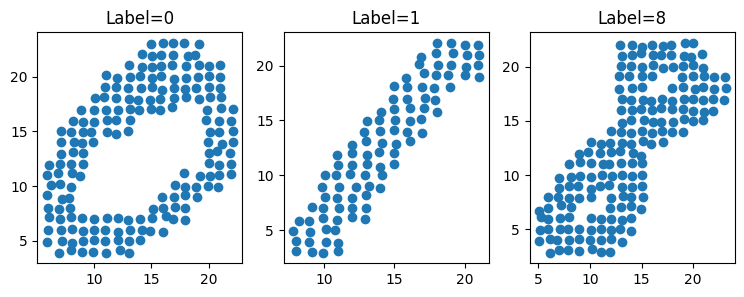

In [3]:
# Here we ensure that the files are accessible in Colab
try:
    with open('./data/data.pkl','rb') as f:
        X,y=pickle.load(f)
except:
    if not os.path.isdir('./data'): 
        os.mkdir('./data')
    os.system('wget -P ./data https://github.com/skolouri/TopoTrans/blob/main/data/data.pkl?raw=true')
    os.rename('./data/data.pkl?raw=true','./data/data.pkl')
    with open('./data/data.pkl','rb') as f:
        X,y=pickle.load(f)
inds = [0,25,51]
fig,ax = plt.subplots(1,3,figsize=(9,3))
for i in range(3):
    ax[i].scatter(X[inds[i]][:,0],X[inds[i]][:,1])
    ax[i].set_title('Label=%d'%y[inds[i]])

### 1.6.3 - Calculate Persistence Diagrams using the Ripser package

Now we are ready to calculate the persistence diagrams using the Ripser package.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


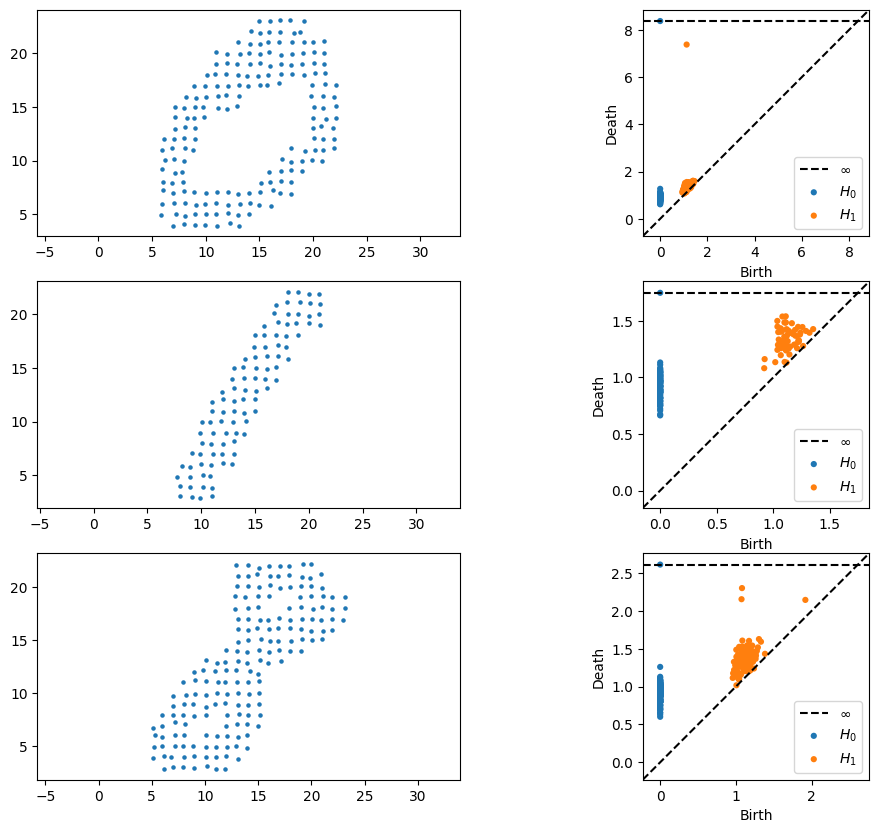

In [4]:
rips = Rips()
fig, axs = plt.subplots(3,2,figsize=(12,10))
for n,i in enumerate(inds):        
    plt.axes(axs[n,0])
    plt.scatter(X[i][:,0],X[i][:,1],s=5)
    plt.axis('equal')
    D=rips.fit_transform(X[i])
    plt.axes(axs[n,1])
    rips.plot(D)

Now we calculate the PDs for all point sets. We will do our analysis based on $H_1$ and to avoid $\infty$ we will set all the $\infty$ values to a large float. 

In [5]:
rips = Rips()
PD = []
for p in X:   
    D = rips.fit_transform(p)
    D = D[1]
    D[D[:,1]==np.inf,1]=1e+2
    PD.append(D)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


### 1.6.4 - Calculating pairwise distances

Here, we first develop a simple function that receives two persistence diagrams, $\mu$ (diagram1) and $\nu$ (diagram2) and then calculate the distance between them through $OT(\tilde{\mu},\tilde{\nu})$.

In [6]:
def otPD(diagram1,diagram2,p=2):
    '''
    This function calculates an optimal partial transport problem 
    between to persistence diagrams.
    
    Inputs
        diagram1 :  A Nx2 numpy array where diagram[:,0] is birth and diagram[:,1] is death
        diagram2 :  A Mx2 numpy array where diagram[:,0] is birth and diagram[:,1] is death
        
    Outputs
        wp : p-Wasserstein distance
        pi : The optimal partial transport plan    
    '''
    N, M = diagram1.shape[0], diagram2.shape[0]
    
    # Calculate diagonal projections per diagram
    diagram1_diagonal_projection = np.stack([diagram1.mean(1),diagram1.mean(1)],1)
    diagram2_diagonal_projection = np.stack([diagram2.mean(1),diagram2.mean(1)],1)

    # Extend both diagrams by the diagonally projected elements from the other diagram, i.e., $\tilde{\mu}$ and $\tilde{\nu}$
    diagram1_extended = np.concatenate([diagram1, diagram2_diagonal_projection],0) # Now (N+M)x2
    diagram2_extended = np.concatenate([diagram2, diagram1_diagonal_projection],0) # Now (N+M)x2
    
    # Calculate the OT problem between $\tilde{\mu}$ and $\tilde{\nu}$
    mass = np.ones((N+M,))/(N+M)
    cost_matrix = ot.dist(diagram1_extended, diagram2_extended,p=p) # Calculate the cost matrix
    cost_matrix[N:,M:] = 0
    pi, log = ot.emd(mass,mass,cost_matrix,log=True)    
    wp=np.power(log['cost'],1/p)
    return wp , pi[:N,:M]

Next we calculate the pairwise distances between the diagrams. 

Wall clock time for calculating pairwise distances between 75 PDs = 6.381451 secs


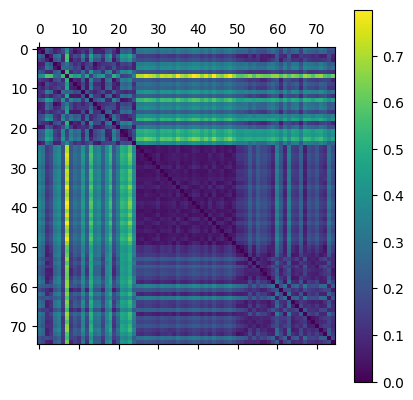

In [7]:
K = len(X)
PD_Dist = np.zeros((K,K))
tic = time.time()
for i in range(K-1):
    for j in range(i+1,K):
        PD_Dist[i,j]=otPD(PD[i],PD[j],p=2)[0]
toc = time.time()
PD_Dist = PD_Dist+PD_Dist.T
plt.matshow(PD_Dist)
plt.colorbar()
print('Wall clock time for calculating pairwise distances between %d PDs = %f secs'%(K,toc-tic))

### 1.6.5 - Manifold learning using the pairwise distances

Now that we have the pairwise distances, we can embedd the persistence diagrams in a d-dimensional vector space using various manifold learning approaches. We first show the results for Multi-Dimensional Scaling (MDS) for embedding the PDs into a 2-dimensional vector space. 

In [8]:
### Calculate MDS Embedding        
np.random.seed(0)
mds = MDS(n_components=2,dissimilarity='precomputed',normalized_stress='auto',n_init=10)
Z = mds.fit_transform(PD_Dist)

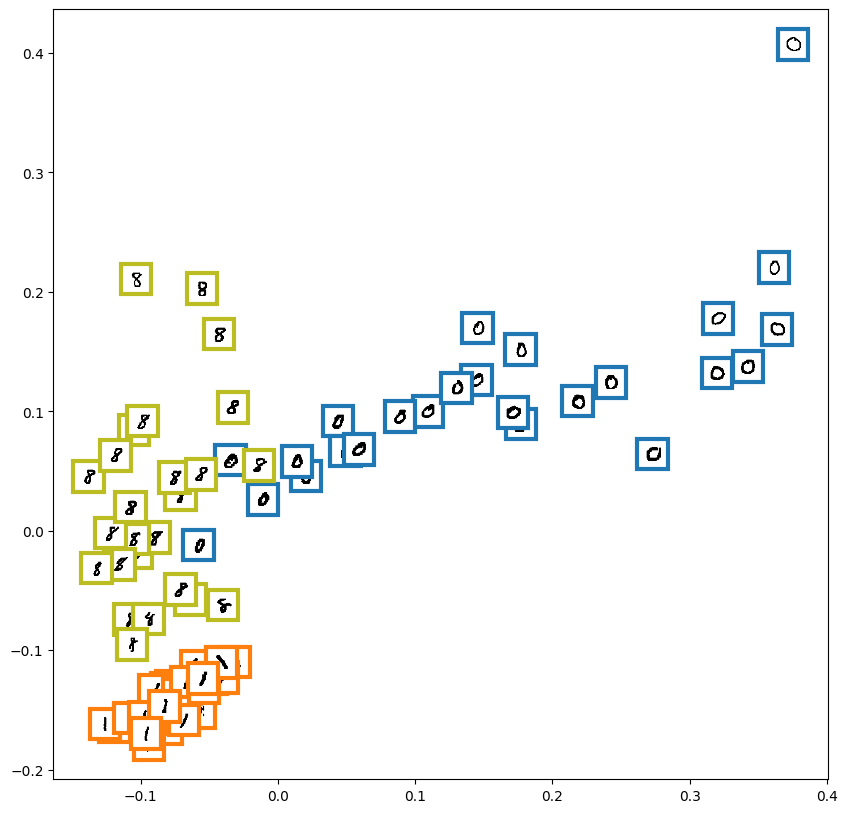

In [9]:
### Generate thumbnail images
img=np.zeros((len(X),28,28))
for n in range(len(X)):
    inds = np.round(X[n]).astype('uint8')
    for i,j in inds:
        img[n,i,27-j]=1
### Visualize Embedded Points
fig,ax = plt.subplots(1,1,figsize=(10,10))
for i,label in enumerate(np.unique(y)):
    ax.scatter(Z[np.array(y)==label,0],Z[np.array(y)==label,1],c='C%d'%i,label=str(label),s=100)
for i in range(Z.shape[0]):
    imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img[i,...].T, cmap=plt.cm.gray_r,zoom=.5), Z[i,:],
            bboxprops =dict(edgecolor='C%d'%y[i],linewidth=3)
        )
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)

Next, we try another classic manifold learning approach Isomap. 

In [10]:
### Calculate Isomap Embedding        
np.random.seed(0)
isomap=Isomap(n_neighbors=5,metric='precomputed')
Z_iso=isomap.fit_transform(PD_Dist)

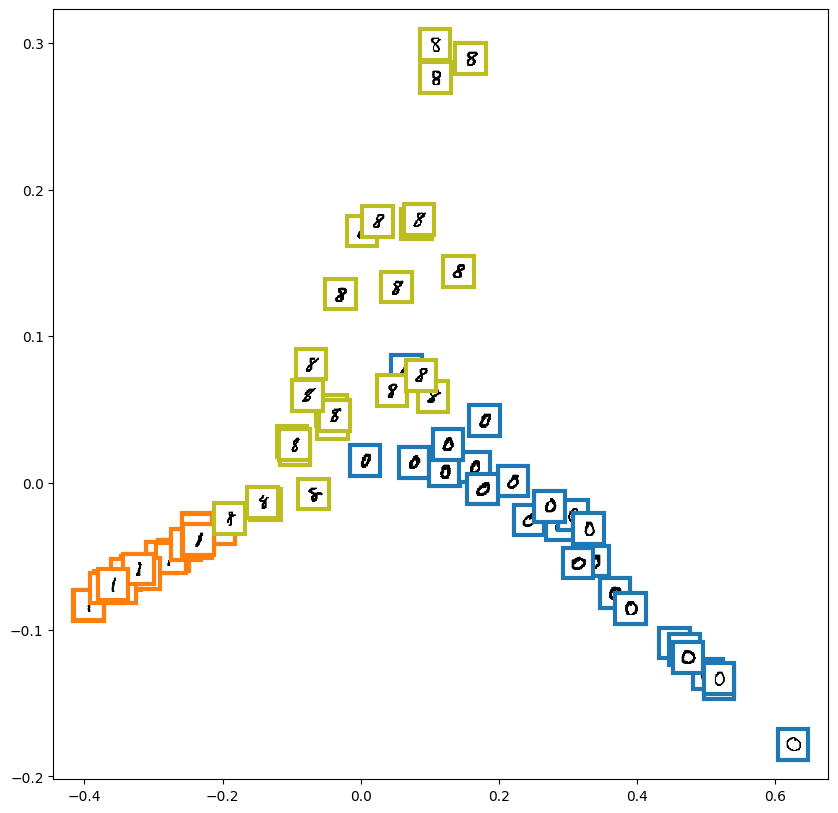

In [11]:
### Visualize the results
fig,ax = plt.subplots(1,1,figsize=(10,10))
for i,label in enumerate(np.unique(y)):
    ax.scatter(Z_iso[np.array(y)==label,0],Z_iso[np.array(y)==label,1],
               c='C%d'%i,label=str(label),s=100)
for i in range(Z_iso.shape[0]):
    imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img[i,...].T, cmap=plt.cm.gray_r,zoom=.5), Z_iso[i,:],
            bboxprops =dict(edgecolor='C%d'%y[i],linewidth=3)
        )
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)

## Part 2 - Sliced Optimal Transport for Comparing Persistence Diagrams

In this part, we will focus on sliced optimal transport (SOT) as a computationally efficient alternative to OT. We will then demonstrate the application of SOT for comparing persistence diagrams.

## Part 2.1 - Optimal Transport Between One-Dimensional Measures

As previously mentioned, the OT problem between two discrete measures can be solved by optimizing linear programming. It is worth noting that this method has a cubic time complexity in the number of mass particles, which can pose a challenge in larger-scale problems. The good news is that for one-dimensional measures, there exists a closed-form solution to the OT problem. Let $\mu$ and $\nu$ be probability measures defined on $\Omega\subseteq\mathbb{R}$ and let $c(x,y)=\|x-y\|_p^p$ denote the transportation cost. Then, the OT problem can be written as: 

$$ OT(\mu, \nu)=\int_0^1 \|F_\mu^{-1}(t)-F_\nu^{-1}(t)\|_p^p dt$$

where $F_\mu(t)=\mu((-\infty,t])$ is the cumulative density function (CDF) and $F_\mu^{-1}$ denotes its inverse, also known as the quantile function. 

For one-dimensional measures $\mu(x)=\sum_{i=1}^N \delta(x-x_i)$ and $\nu(y)=\sum_{j=1}^N \delta(y-y_j)$, the optimal transport is obtained via sorting $\{x_i\}_{i=1}^N$ and $\{y_j\}_{j=1}^N$, 

$$ OT(\mu, \nu)= \sum_{i=1}^N \|x_{\sigma(i)}-y_{\kappa(j)}\|_p^p,$$

where $\sigma$ and $\kappa$ denote the sorted indices of $\{x_i\}_{i=1}^N$ and $\{y_j\}_{j=1}^N$, respectively. See Figure below.

![](./src/sliced.png)

## Part 2.2 - Sliced Optimal Transport

The closed form solution of OT for one-dimensional probability measures motivates the introduction of Sliced Optimal Transport. The notion of slicing a d-dimensional probability measure (d>1) is deeply rooted in integral geometry and the celebrated Radon transform. Let $\mu$ be a d-dimensional probability measure defined on $\Omega\subseteq\mathbb{R}^d$, and let $\theta\in\mathbb{S}^{(d-1)}$ denote a unit vector in $\mathbb{R}^d$. Then, a one-dimensional slice of $\mu$ with respect to $\theta$ is written as $\theta_\#\mu$, s.t., $\theta_\#\mu(t)=\mu(H(t;\theta))$ and $H(t;\theta):=\{x | x\cdot \theta = t\}$. Then one can define the Sliced OT problem as follows [[7]](#references): 

$$ SOT(\mu,\nu):=\int_{\mathbb{S}^{d-1}} OT(\theta_\#\mu,\theta_\#\nu)d\sigma(\theta)$$

where $\sigma$ is a probability measure with $supp(\sigma)=\mathbb{S}^{d-1}$. In practice, we often set $\sigma$ to be the uniform measure on $\mathbb{S}^{d-1}$. Given that in practice we cannot integrate over $\mathbb{S}^{d-1}$, we use Monte Carlo integration to approximate it. In short, let $\{\theta_l\sim \mathcal{U}(\mathbb{S}^{d-1})\}_{k=1}^K$ denote $K$ i.i.d. samples from the uniform distribution on $\mathbb{S}^{d-1}$, then the above mentioned integral can be approximated via: 

$$ SOT(\mu,\nu)\approx \frac{1}{K}\sum_{k=1}^K OT((\theta_{k})_\#\mu,(\theta_k)_\#\nu)$$

The beauty of the above equation is that the summation on $K$ could be parallelized and the OT problem has a closed form solution, which leads to a very efficient calculation of SOT. Moreover, when OT provides a metric on probability measures (i.e., the Wasserstein distance) then the SOT is also a metric. The figure below visualizes the process of calculating SOT between two 2D probability measures.

![](./src/SOT.png)

## 2.3 - Measuring distances between PDs with SOT

In Part 1, we saw that the OPT problem associated with the PD distances can be turned into an OT problem by adding additional "source" and "sink" particles such that transportation cost to these source and sink particles is equal to the creation and destruction cost. This was possible by updating measures $\mu$ and $\nu$ into $\tilde{\mu}(x)=\sum_{i=1}^N \delta(x-x_i)+\sum_{j=1}^M \delta(y-\pi_\Delta(y_j))$ and $\tilde{\nu}(y)=\sum_{i=1}^M \delta(y-y_j)+\sum_{i=1}^N \delta(x-\pi_\Delta(x_i))$, respectively, and calculating $OT(\tilde{\mu},\tilde{\nu})$. Alternatively, one can use $SOT(\tilde{\mu},\tilde{\nu})$, which can be calculated much more efficiently [[8]](#references).

## 2.4 - Code

In what follows we implement the Sliced Wasserstein distance between PDs, and repeat the experiments from Part 1. 

### 2.4.1 - Calculate pairwise distance

In [12]:
def sotPD(diagram1,diagram2,K=32,p=2,seed=0):
    '''
    This function calculates an sliced optimal partial transport problem 
    between to persistence diagrams.
    
    Inputs
        diagram1 :  A Nx2 numpy array where diagram[:,0] is birth and diagram[:,1] is death
        diagram2 :  A Mx2 numpy array where diagram[:,0] is birth and diagram[:,1] is death
        K:          Number of projections for Monte Carlo integration
        p:          The distance order
        seed:       Random seed
        
    Outputs
        swp : Sliced p-Wasserstein distance       
    '''
    N, M = diagram1.shape[0], diagram2.shape[0]
    
    # Calculate diagonal projections per diagram
    diagram1_diagonal_projection = np.stack([diagram1.mean(1),diagram1.mean(1)],1)
    diagram2_diagonal_projection = np.stack([diagram2.mean(1),diagram2.mean(1)],1)

    # Extend both diagrams by the diagonally projected elements from the other diagram, i.e., $\tilde{\mu}$ and $\tilde{\nu}$
    diagram1_extended = np.concatenate([diagram1, diagram2_diagonal_projection],0) # Now (N+M)x2
    diagram2_extended = np.concatenate([diagram2, diagram1_diagonal_projection],0) # Now (N+M)x2
    
    # Generate random slicers
    np.random.seed(seed)
    theta = np.random.randn(2,K)
    theta /= (theta**2).sum(0)[np.newaxis,:]

    # Slice distributions
    diagram1_extended_sliced = diagram1_extended@theta # Now (N+M)xK
    diagram2_extended_sliced = diagram2_extended@theta # Now (N+M)xK
    
    # Sort along the first dimension
    diagram1_extended_sliced_sorted = np.sort(diagram1_extended_sliced,axis=0)
    diagram2_extended_sliced_sorted = np.sort(diagram2_extended_sliced,axis=0)
    
    # Calculate SOT
    swp = np.power(((diagram1_extended_sliced_sorted-diagram2_extended_sliced_sorted)**p).sum(0).mean(),1/p)
    return swp

Wall clock time for calculating pairwise distances between 75 PDs = 0.243674 secs
As can be seen, SOT is 26x faster that OT


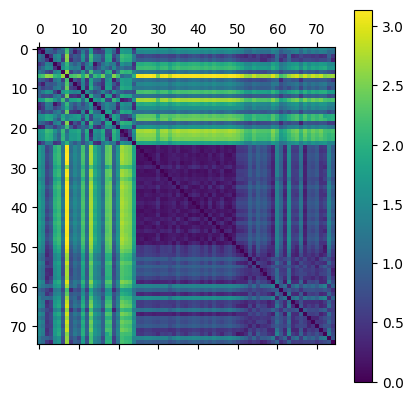

In [13]:
K = len(X)
PD_Dist = np.zeros((K,K))
tic2 = time.time()
for i in range(K-1):
    for j in range(i+1,K):
        PD_Dist[i,j]=sotPD(PD[i],PD[j],K=5,p=2,seed=0)
toc2 = time.time()
PD_Dist = PD_Dist+PD_Dist.T
plt.matshow(PD_Dist)
plt.colorbar()
print('Wall clock time for calculating pairwise distances between %d PDs = %f secs'%(K,toc2-tic2))
print('As can be seen, SOT is %dx faster that OT'%np.round((toc-tic)/(toc2-tic2)))

### 2.4.2 - Manilfold learning using the pairwise distance

Now that we have the pairwise distances, we can embedd the persistence diagrams in a d-dimensional vector space using various manifold learning approaches. We first show the results for Multi-Dimensional Scaling (MDS) for embedding the PDs into a 2-dimensional vector space. 

In [14]:
### Calculate MDS Embedding        
np.random.seed(0)
mds = MDS(n_components=2,dissimilarity='precomputed',normalized_stress='auto',n_init=10)
Z = mds.fit_transform(PD_Dist)

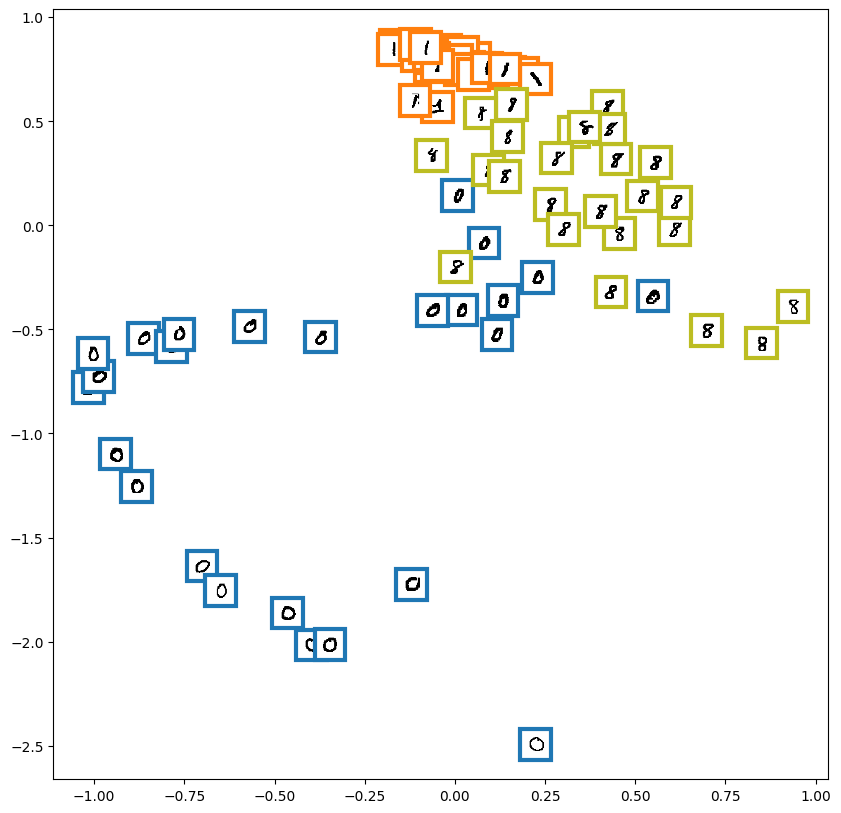

In [15]:
### Visualize Embedded Points
fig,ax = plt.subplots(1,1,figsize=(10,10))
for i,label in enumerate(np.unique(y)):
    ax.scatter(Z[np.array(y)==label,0],Z[np.array(y)==label,1],c='C%d'%i,label=str(label),s=100)
for i in range(Z.shape[0]):
    imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img[i,...].T, cmap=plt.cm.gray_r,zoom=.5), Z[i,:],
            bboxprops =dict(edgecolor='C%d'%y[i],linewidth=3)
        )
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)

Next, we try another classic manifold learning approach Isomap. 

In [16]:
### Calculate Isomap Embedding        
np.random.seed(0)
isomap=Isomap(n_neighbors=5,metric='precomputed')
Z_iso=isomap.fit_transform(PD_Dist)

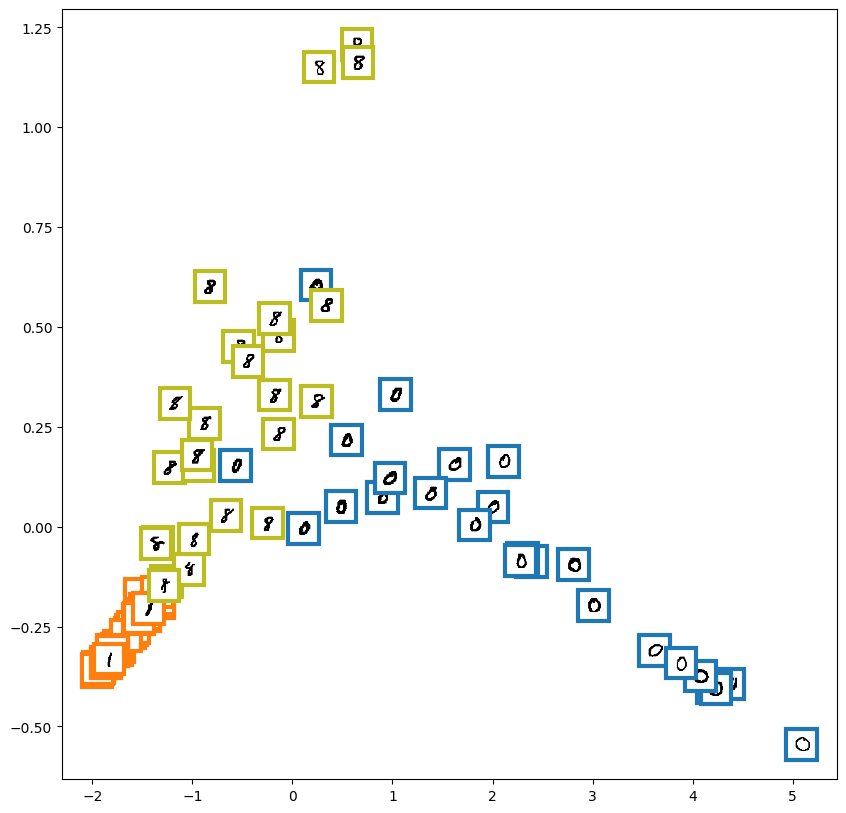

In [17]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
for i,label in enumerate(np.unique(y)):
    ax.scatter(Z_iso[np.array(y)==label,0],Z_iso[np.array(y)==label,1],
               c='C%d'%i,label=str(label),s=100)
for i in range(Z_iso.shape[0]):
    imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img[i,...].T, cmap=plt.cm.gray_r,zoom=.5), Z_iso[i,:],
            bboxprops =dict(edgecolor='C%d'%y[i],linewidth=3)
        )
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)

<a id='references'></a>
## References

[1] Lacombe, Théo, Marco Cuturi, and Steve Oudot. "Large scale computation of means and clusters for persistence diagrams using optimal transport." Advances in Neural Information Processing Systems 31 (2018).

[2] Peyré, Gabriel, and Marco Cuturi. "Computational optimal transport: With applications to data science." Foundations and Trends® in Machine Learning 11, no. 5-6 (2019): 355-607.

[3] Figalli, Alessio. "The optimal partial transport problem." Archive for rational mechanics and analysis 195, no. 2 (2010): 533-560.

[4] Bai, Yikun, Bernard Schmitzer, Mathew Thorpe, and Soheil Kolouri. "Sliced optimal partial transport." arXiv preprint arXiv:2212.08049 (2022).

[5] Divol, Vincent, and Théo Lacombe. "Understanding the topology and the geometry of the space of persistence diagrams via optimal partial transport." Journal of Applied and Computational Topology 5 (2021): 1-53.

[6] Rémi Flamary, Nicolas Courty, Alexandre Gramfort, Mokhtar Z. Alaya, Aurélie Boisbunon, Stanislas Chambon, Laetitia Chapel, Adrien Corenflos, Kilian Fatras, Nemo Fournier, Léo Gautheron, Nathalie T.H. Gayraud, Hicham Janati, Alain Rakotomamonjy, Ievgen Redko, Antoine Rolet, Antony Schutz, Vivien Seguy, Danica J. Sutherland, Romain Tavenard, Alexander Tong, Titouan Vayer, POT Python Optimal Transport library, Journal of Machine Learning Research, 22(78):1−8, 2021. Website: https://pythonot.github.io/

[7] Rabin, Julien, Gabriel Peyré, Julie Delon, and Marc Bernot. "Wasserstein barycenter and its application to texture mixing." In Scale Space and Variational Methods in Computer Vision: Third International Conference, SSVM 2011, Ein-Gedi, Israel, May 29–June 2, 2011, Revised Selected Papers 3, pp. 435-446. Springer Berlin Heidelberg, 2012.

[8] Carriere, Mathieu, Marco Cuturi, and Steve Oudot. "Sliced Wasserstein kernel for persistence diagrams." In International conference on machine learning, pp. 664-673. PMLR, 2017.

[9] Caffarelli, Luis A., and Robert J. McCann. "Free boundaries in optimal transport and Monge-Ampere obstacle problems." Annals of mathematics (2010): 673-730.

[10] Sato, R., Yamada, M., & Kashima, H. (2020). Fast unbalanced optimal transport on a tree. Advances in neural information processing systems, 33, 19039-19051.